In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import torch, torch.nn as nn, torch.nn.functional as F
from torch import tensor
from torch.utils.data import DataLoader
from torcheval.metrics import MulticlassAccuracy
from torch.optim import lr_scheduler
import sys, traceback, gc
import fastcore.all as fc
from functools import partial

from miniai.data import *
from miniai.learner import TrainLearner, MomentumLearner
from miniai.callbacks import *
from miniai.hooks import *
from miniai.custom_modules import conv, GeneralReLU
from miniai.plotting import subplots

sns.set()

In [3]:
data = pd.read_csv('data/fashion_mnist/train.csv')

In [4]:
X_train = (tensor(data.iloc[:50000, 1:].values)/255.).view(-1, 1, 28, 28)
y_train = tensor(data.iloc[:50000, 0].values)
X_valid = (tensor(data.iloc[50000:, 1:].values)/255.).view(-1, 1, 28, 28)
y_valid = tensor(data.iloc[50000:, 0].values)

In [5]:
class FashionDataset(Dataset):
    def __init__(self, x, y, mean=None, std=None):
        self.mean = mean; self.std = std
        if self.mean is None: self.mean = x.mean()
        if self.std is None: self.std = x.std()
        self.x = (x - self.mean) / self.std
        self.y = y

In [18]:
dset_train = FashionDataset(X_train[:2000], y_train[:2000])
dset_valid = FashionDataset(X_valid[:2000], y_valid[:2000], dset_train.mean, dset_train.std)

In [19]:
dl_train = DataLoader(dset_train, batch_size=128, shuffle=True, num_workers=4)
dl_valid = DataLoader(dset_valid, batch_size=len(dset_valid), shuffle=False,  num_workers=4)

In [20]:
dls = DataLoaders(dl_train, dl_valid)

<br>**Model**

In [9]:
class SGD:
    def __init__(self, params, lr=1e-3, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if self.wd != 0: self.reg_step(p)
                self.opt_step(p)
        self.i += 1
    def reg_step(self, p):
        p *= (1 - self.wd*self.lr)
    def opt_step(self, p):
        p -= p.grad*self.lr
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [10]:
class MomentumSGD(SGD):
    def __init__(self, params, lr=1e-3, wd=0., mom=0.85):
        super(MomentumSGD, self).__init__(params, lr, wd)
        self.mom = mom
    def opt_step(self, p):
        if not hasattr(p, 'mom_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg  = self.mom*p.grad_avg + (1-self.mom)*p.grad
        p -= p.grad_avg*self.lr

In [11]:
class Adam(SGD):
    def __init__(self, params, lr=1e-3, wd=0., beta1=0.9, beta2=0.99, eps=1e-2):
        super(Adam, self).__init__(params, lr, wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad)
        p.avg  = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbiased_avg = p.avg / (1 - self.beta1**(self.i+1))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*p.grad**2
        unbiased_sqr_avg = p.sqr_avg / (1 - self.beta2**(self.i+1))
        p -= self.lr * unbiased_avg/(unbiased_sqr_avg.sqrt() + self.eps)

In [12]:
class SingleBatchCB(Callback):
    k = 0
    def after_batch(self, learn): 
        if self.k > 2: raise CancelFitException()
        self.k += 1

In [13]:
def _lr(pg): return pg['lr']
def _beta1(pg): return pg['betas'][0]

In [14]:
def init_weights(m, leaky=0.): 
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): nn.init.kaiming_normal_(m.weight, a=leaky)

In [21]:
act_func = GeneralReLU(sub=0.4, leaky=0.1)
model = nn.Sequential(
    conv(1, 8, act=act_func), #14×14
    nn.BatchNorm2d(8),
    conv(8, 16, act=act_func), #7×7
    nn.BatchNorm2d(16),
    conv(16, 32, act=act_func), #4×4
    nn.BatchNorm2d(32),
    conv(32, 64, act=act_func), #2×2
    conv(64, 10, act=None), #1×1
    nn.Flatten(),
)

model = model.apply(partial(init_weights, leaky=0.1))

In [27]:
lr_scheduler.OneCycleLR??

In [22]:
epochs = 6
sched = partial(lr_scheduler.OneCycleLR, max_lr=5e-2, total_steps=epochs*len(dls.train))
sched_cb = BatchSchedCB(sched)
rec = RecorderCB(lr=_lr, beta1=_beta1)
learn = TrainLearner(dls, model, F.cross_entropy, torch.optim.AdamW,
                cbs=[sched_cb, rec, MetricCB(accuracy=MulticlassAccuracy()), ProgressCB()])

In [23]:
learn.fit(epochs, 8e-3)

epoch,train_loss,valid_loss,accuracy
0,1.231,1.63,0.613
1,1.094,1.293,0.697
2,0.693,0.714,0.753
3,0.514,0.619,0.793
4,0.382,0.566,0.787
5,0.286,0.527,0.803


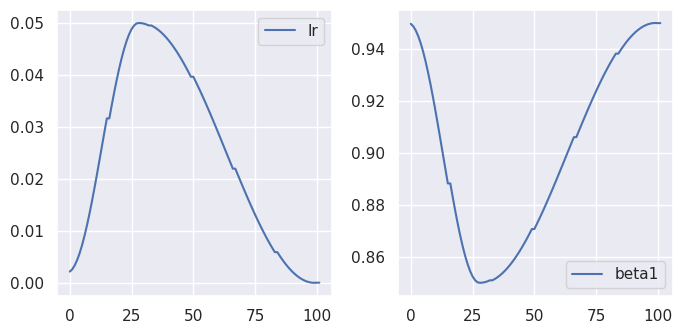

In [24]:
rec.plot(imsize=[3.5, 3.5])